# CH7 범주형 데이터 이진분류 경진대회

## 7.4 성능 개선
- 다음 세가지 포인트를 통해 모델의 성능을 개선하겠음
1. 피처 맞춤 인코딩
2. 피처 스케일링
3. 하이퍼 파라미터 최적화(그리드 서치)  
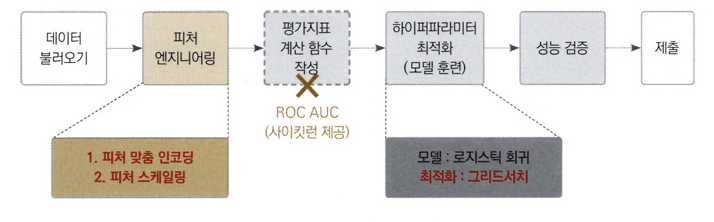

### 7.4.1 피처 엔지니어링 1: 피처 맞춤 인코딩
- 이진피처-순서형피처-명목형피처-날짜피처 순으로 인코딩 진행  
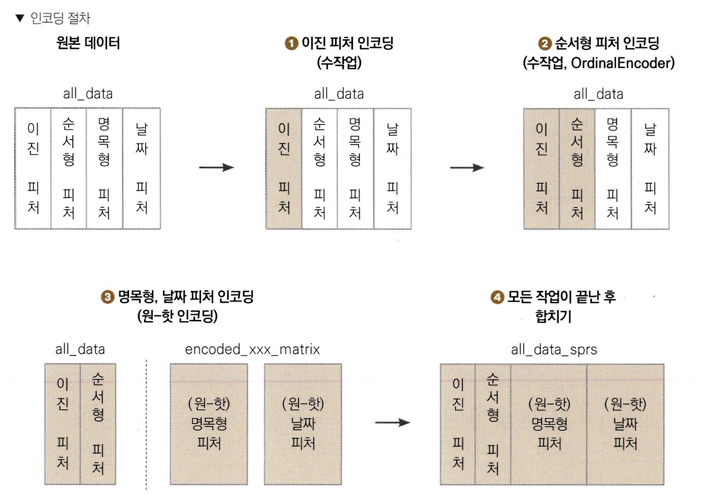

#### 7.4.1.1 이진 피처 인코딩

In [1]:
import pandas as pd
data_path = '/kaggle/input/cat-in-the-dat/'
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

# 훈련 데이터와 테스트 데이터 합치기 
all_data = pd.concat([train, test]) 
all_data = all_data.drop('target', axis=1) # 타깃값 제거

# bin_0~2는 이미 0과 1로 표현되어 있으므로, bin_3~4만 인코딩하면 됨
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})

#### 7.4.1.2 순서형 피처 인코딩

In [2]:
from sklearn.preprocessing import OrdinalEncoder

#(1) ord_0은 이미 숫자 데이터이므로 인코딩 필요 없음
#(2) ord_1, ord_2를 고윳값의 순서에 맞춰 인코딩
ord1dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}
all_data['ord_1'] = all_data['ord_1'].map(ord1dict) 
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

#(3) ord_3~5를 각각 고윳값의 알파벳 순서에 맞춰 인코딩
ord_345 = ['ord_3', 'ord_4', 'ord_5']
ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])
# 피처별 인코딩 순서 출력
for feature, categories in zip(ord_345, ord_encoder.categories_): 
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

#### 7.4.1.3 명목형 피처 인코딩
* OneHotEncoder를 사용하면 희소행렬(대부분의 값이 0으로 채워진 행렬)을 CSR 형식으로 반환함  
  - 희소행렬을 그대로 사용하면 메모리 낭비도 심해지고 연산시간도 오래 걸려서 비효율적  
  - 따라서 0이 아닌 값만을 저장하여 행렬을 효율적으로 다루는 COO, CSR 형식을 사용함  

In [3]:
from sklearn.preprocessing import OneHotEncoder

nom_features = ['nom_' + str(i) for i in range(10)] # 명목형 피처 리스트

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])
encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

In [4]:
all_data = all_data.drop(nom_features, axis=1) # 중복을 막기 위해 기존 명목형 피처 삭제

### **COO(Coordinate) 형식**
  - 0이 아닌 값의 행(row), 열(column), 데이터(data)를 각각 하나의 배열로 저장  
    row: 0이 아닌 값이 있는 행 인덱스 리스트  
    col: 0이 아닌 값이 있는 열 인덱스 리스트  
    data: 0이 아닌 값들 자체의 리스트  
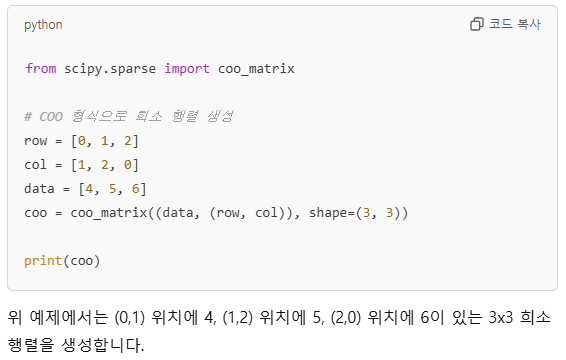  
  
### **CSR(compressed sparse row) 형식**  
  - 행 단위로 압축하여 저장하는 방법. data, col, row_pos_ind 를 각각 하나의 배열로 저장  
    data: 0이 아닌 값들 자체의 리스트  
    col: 0이 아닌 값이 있는 열 인덱스 리스트  
    row_pos_ind: 0이 아닌 값이 있는 행 인덱스 리스트(COO 참조) 내에서 고유값의 시작 위치  
  - data, col은 COO와 같다. 그렇다면 다음 예제를 통해 row_pos_ind를 이해해 보자  


### **예제**  
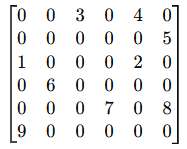  
1. COO 형식으로 표현하면 다음과 같다
   - data: [3, 4, 5, 1, 2, 6, 7, 8, 9]
   - row: [0, 0, 1, 2, 2, 3, 4, 4, 5]
   - col: [2, 4, 5, 0, 4, 1, 3, 5, 0]  
       
2. 그런데 여기서 row 배열은 같은 숫자가 순차적으로 반복된다. 이 배열을 압축하여 표현하자.
   - 숫자 0은 인덱스 0에서 시작  
   - 숫자 1은 인덱스 2에서 시작  
   - 숫자 2는 인덱스 3에서 시작  
   - 숫자 3은 인덱스 5에서 시작  
   - 숫자 4는 인덱스 6에서 시작  
   - 숫자 5는 인덱스 8에서 시작  
   - 숫자는 총 9개  
   - row_pos_ind = [0, 2, 3, 5, 6, 8, 9]  
        
3. 압축하여 표현하였더니 CSR 형식의 row_pos_ind 배열이 완성되었다. CSR 형식은 다음과 같다.
   - data: [3, 4, 5, 1, 2, 6, 7, 8, 9]
   - col: [2, 4, 5, 0, 4, 1, 3, 5, 0]
   - row_pos_ind = [0, 2, 3, 5, 6, 8, 9]   

#### 7.4.1.4 날짜 피처 인코딩
- 원핫 인코딩으로 수행

In [5]:
################## (2) 원핫 인코딩
date_features = ['day', 'month'] # 날짜 피처
# 원-핫 인코딩 적용
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제
encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

### 7.4.2 피처 엔지니어링 2: 피처 스케일링
- 순서형 피처의 값 범위를 0~1 사이로 스케일링 하겠음
- min-max 정규화

In [6]:
from sklearn.preprocessing import MinMaxScaler
ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처
# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

* 인코딩 및 스케일링된 피처 합치기

In [7]:
from scipy import sparse
import numpy as np
# 날짜 피처가 원-핫 인코딩 된 경우
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data), encoded_nom_matrix, encoded_date_matrix], format='csr')

* 훈련 데이터와 테스트 데이터 나누기

In [8]:
num_train = len(train) # 훈련 데이터 개수
# 훈련 데이터와 테스트 데이터 나누기 (날짜 피처가 원-핫 인코딩 된 경우)
X_train = all_data_sprs[:num_train] # 0~num_train 행 
X_test = all_data_sprs[num_train:] # ~마지막 행
y = train['target']

* 훈련데이터 -> 훈련데이터와 검증데이터로 나누기

In [9]:
from sklearn.model_selection import train_test_split
# 훈련 데이터, 검증 데이터 분리 (날짜 피처가 원-핫 인코딩 된 경우)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.1, stratify=y, random_state=10)

### 7.4.3 하이퍼 파라미터 최적화
- 그리드 서치를 활용해 로지스틱 회귀모델의 하이퍼파라미터 최적화  
- 탐색할 하이퍼파라미터는 C와 max_iter  
  1. C는 regularization(규제)의 강도를 조절한다.  
     C가 작으면 모델이 단순해지며 과소적합(underfitting)의 위험이 있다.  
     C가 크면 모델이 복잡해지며 과적합(overfitting)의 위험이 있다.  
  2. max_iter은 알고리즘의 반복 횟수를 제한하는 역할을 한다.  
     즉 지정된 max_iter 횟수만큼만 모델이 학습한다.  
     max_iter 값이 너무 작으면 모델이 충분히 수렴하지 않아 성능이 저하될 수 있다.  
     max_iter 값이 너무 크면 학습 시간이 길어지고 과적합의 위험이 있다.  

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression

############ 하이퍼파라미터 최적화 
# 로지스틱 회귀 모델 생성
logistic_model = LogisticRegression()
# 하이퍼파라미터 값 목록 
lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 'solver':['liblinear'], 'random_state':[42]}
# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(estimator=logistic_model, param_grid=lr_params, scoring='roc_auc', cv=5)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)
print('최적 하이퍼파라미터：', gridsearch_logistic_model.best_params_)

최적 하이퍼파라미터： {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
CPU times: user 18min 6s, sys: 13min 33s, total: 31min 40s
Wall time: 8min 14s


### 7.4.4 모델 성능 검증
- 최적의 하이퍼 파라미터를 사용하여 성능이 얼만큼 향상됬는지 확인

In [ ]:
from sklearn.metrics import roc_auc_score 

# 성능 검증 
y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC : {roc_auc: .4f}')

검증 데이터 ROC AUC :  0.8045


### 7.4.5 예측 및 결과 제출

In [ ]:
# 타깃값 1일 확률 예측
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]
 # 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission.csv')

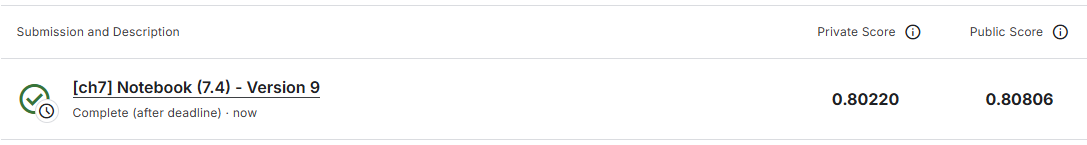  
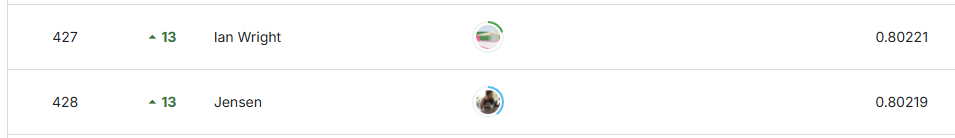  
- 7.3의 기본 베이스 모델(0.79612) 보다 0.00608 향상된 점수이다
- 순위를 찾아보니 베이스 모델(705등) 보다 향상된 428등이다. 